# TFM
# Modelo Sarima

Realizado por: Luis Rendón  <br>
Fecha: DIC/2022

### Importación de librerias necesarias

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para manejo de fechas
from datetime import datetime

# Para modelos SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

# Para métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error




### Cargar el Dataset

In [21]:
# Specify the path to your Excel file
file_path = "https://github.com/huambra/Predicting-Shrimp-Exports/raw/refs/heads/main/Exports%20por%20Mercado.xlsx"

# Read the Excel file
df = pd.read_excel(file_path, sheet_name="Unpivot")

# Display the first few rows of the dataframe
print(df.head())

        Date  China   USA    UE
0 2012-12-01   19.0   291    75
1 2013-01-01  740.0  4119  4241
2 2013-02-01  380.0  5844  5407
3 2013-03-01  459.0  6929  7510
4 2013-04-01  403.0  7266  7830


In [3]:
df

,Date,China,USA,UE
0,2012-12-01,19.0,291,75
1,2013-01-01,740.0,4119,4241
2,2013-02-01,380.0,5844,5407
3,2013-03-01,459.0,6929,7510
4,2013-04-01,403.0,7266,7830
...,...,...,...,...
136,2024-04-01,61599.0,18589,17849
137,2024-05-01,68663.0,24101,18514
138,2024-06-01,60804.0,14983,17458
139,2024-07-01,49431.0,15963,20369


### Caracteristicas del Dataset (EDA)

In [4]:
# Mostrar información general del dataset
print("Información del dataset:")
print(df.info())

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    141 non-null    datetime64[ns]
 1   China   141 non-null    float64       
 2   USA     141 non-null    int64         
 3   UE      141 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 4.5 KB
None


El dataset cuenta con 141 entradas y 4 columnas, de las cuales la columna `Date` tiene un valor nulo que sería importante gestionar según el análisis requerido. Las columnas tienen tipos de datos adecuados para análisis: `Date` como `datetime64[ns]` para análisis temporales, y `China`, `USA`, y `UE` como `int64` para representar datos numéricos. Los nombres de las columnas son claros, pero podrían estandarizarse para facilitar el manejo automatizado del dataset. Además, es crucial verificar la consistencia de las filas para identificar posibles valores atípicos o inconsistencias, y asegurarse de que las fechas en la columna `Date` estén ordenadas cronológicamente antes de proceder con análisis de series temporales.

In [5]:
# Describir las estadísticas básicas
print("\nEstadísticas descriptivas:")
print(df.describe())

# Convertir la columna 'Date' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Verificar valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())


Estadísticas descriptivas:
                                Date         China           USA            UE
count                            141    141.000000    141.000000    141.000000
mean   2018-10-01 02:22:58.723404288  21722.612464  10762.780142  10523.546099
min              2012-12-01 00:00:00     19.000000    291.000000     75.000000
25%              2015-11-01 00:00:00    977.000000   6089.000000   7156.000000
50%              2018-10-01 00:00:00  11356.000000   7837.000000   9404.000000
75%              2021-09-01 00:00:00  43267.000000  15184.000000  13267.000000
max              2024-08-01 00:00:00  70663.000000  39246.000000  29692.000000
std                              NaN  22768.348255   6432.901489   4644.267884

Valores nulos por columna:
Date     0
China    0
USA      0
UE       0
dtype: int64


El dataset abarca un periodo temporal desde diciembre de 2012 hasta agosto de 2024, proporcionando un rango amplio para análisis de tendencias a largo plazo. La columna `Date` no presenta valores nulos, lo que asegura la continuidad de las observaciones temporales. Las columnas numéricas (`China`, `USA` y `UE`) muestran diferencias significativas entre los valores mínimos y máximos, lo que indica una alta variabilidad en los datos. La desviación estándar es particularmente alta en la columna `China` (25,406.0) en comparación con las demás, lo que sugiere la presencia de valores extremos o una distribución dispersa. Por otro lado, las columnas `USA` y `UE` presentan rangos más moderados pero aún muestran una considerable dispersión. Este comportamiento resalta la importancia de normalizar o escalar los datos si se utilizarán en modelos predictivos. Además, las diferencias entre los percentiles (`25%`, `50%` y `75%`) confirman distribuciones asimétricas que podrían impactar los análisis futuros, especialmente en el caso de series temporales o evaluaciones basadas en patrones regionales.

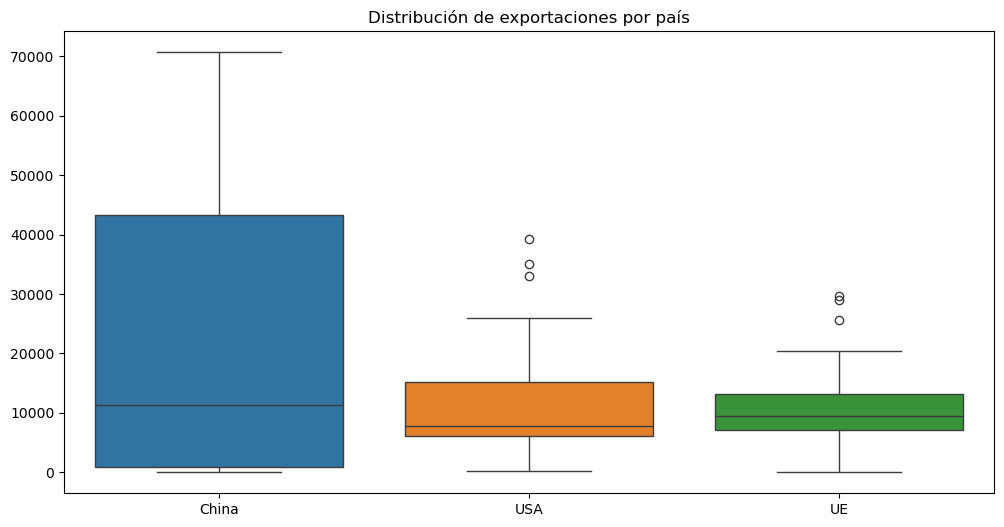

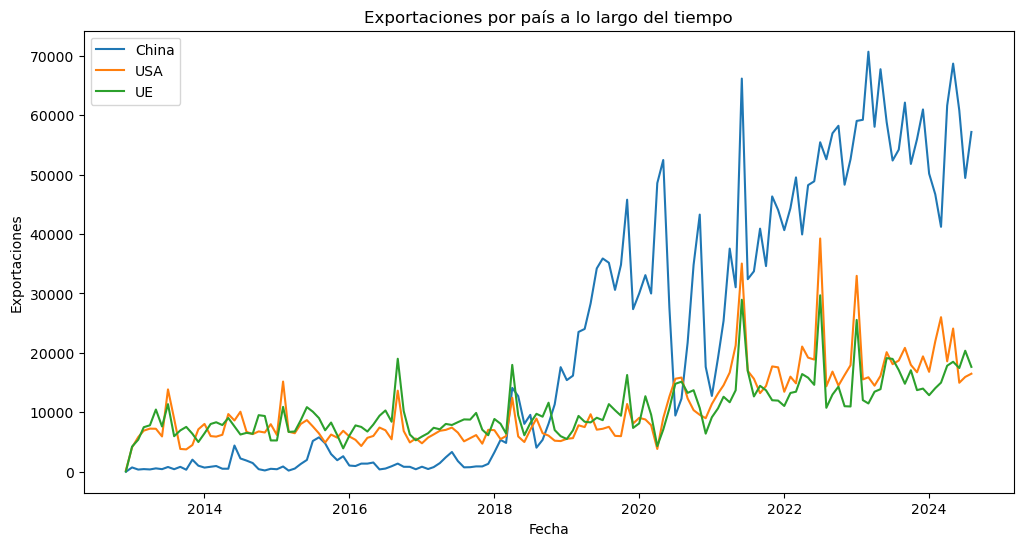

In [6]:
# Visualizar la distribución de los datos
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['China', 'USA', 'UE']])
plt.title('Distribución de exportaciones por país')
plt.show()

# Visualizar las series temporales
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['China'], label='China')
plt.plot(df['Date'], df['USA'], label='USA')
plt.plot(df['Date'], df['UE'], label='UE')
plt.xlabel('Fecha')
plt.ylabel('Exportaciones')
plt.title('Exportaciones por país a lo largo del tiempo')
plt.legend()
plt.show()

Agregar comentarios de el analisis

### Preprocesamiento del Dataset
aqui hay que hacer hasta dividir los 3 datasets por pais listos para que se puedan modelar en cualquiera de lso 3 modelos. Para ciertos modelos peude haber mas preprocesamiento eso es cuestion de cada uno.

In [22]:
# Dividir el dataframe por país y establecer la columna 'Date' como índice
df_china = df[['Date', 'China']].set_index('Date')
df_usa = df[['Date', 'USA']].set_index('Date')
df_ue = df[['Date', 'UE']].set_index('Date')

# Mostrar las primeras filas de cada dataframe
print("Datos de China:")
print(df_china.head())

print("\nDatos de USA:")
print(df_usa.head())

print("\nDatos de UE:")
print(df_ue.head())

Datos de China:
            China
Date             
2012-12-01   19.0
2013-01-01  740.0
2013-02-01  380.0
2013-03-01  459.0
2013-04-01  403.0

Datos de USA:
             USA
Date            
2012-12-01   291
2013-01-01  4119
2013-02-01  5844
2013-03-01  6929
2013-04-01  7266

Datos de UE:
              UE
Date            
2012-12-01    75
2013-01-01  4241
2013-02-01  5407
2013-03-01  7510
2013-04-01  7830


### Prueba Chat

In [23]:
# Convertir índice a datetime
df_china.index = pd.to_datetime(df_china.index, format='%d/%m/%Y')
# Asegurar frecuencia mensual
df_china = df_china.asfreq('MS')  # MS = Start of Month

# Repetir con df_usa y df_ue si fuera necesario
df_usa.index = pd.to_datetime(df_usa.index, format='%d/%m/%Y')
df_usa = df_usa.asfreq('MS')

df_ue.index = pd.to_datetime(df_ue.index, format='%d/%m/%Y')
df_ue = df_ue.asfreq('MS')


In [6]:
# Definimos el tamaño del test, por ejemplo, 12 observaciones (12 meses)
n_test = 12

# 4.1. Para CHINA
train_china = df_china.iloc[:-n_test].copy()
test_china  = df_china.iloc[-n_test:].copy()

print("CHINA:")
print("Tamaño de entrenamiento:", train_china.shape)
print("Tamaño de prueba:", test_china.shape)
print("Fechas de entrenamiento:", train_china.index.min(), " a ", train_china.index.max())
print("Fechas de prueba:", test_china.index.min(), " a ", test_china.index.max())
print("-------------------------------------------------------\n")

# 4.2. Para USA
train_usa = df_usa.iloc[:-n_test].copy()
test_usa  = df_usa.iloc[-n_test:].copy()

print("USA:")
print("Tamaño de entrenamiento:", train_usa.shape)
print("Tamaño de prueba:", test_usa.shape)
print("Fechas de entrenamiento:", train_usa.index.min(), " a ", train_usa.index.max())
print("Fechas de prueba:", test_usa.index.min(), " a ", test_usa.index.max())
print("-------------------------------------------------------\n")

# 4.3. Para UE
train_ue = df_ue.iloc[:-n_test].copy()
test_ue  = df_ue.iloc[-n_test:].copy()

print("UE:")
print("Tamaño de entrenamiento:", train_ue.shape)
print("Tamaño de prueba:", test_ue.shape)
print("Fechas de entrenamiento:", train_ue.index.min(), " a ", train_ue.index.max())
print("Fechas de prueba:", test_ue.index.min(), " a ", test_ue.index.max())




CHINA:
Tamaño de entrenamiento: (129, 1)
Tamaño de prueba: (12, 1)
Fechas de entrenamiento: 2012-12-01 00:00:00  a  2023-08-01 00:00:00
Fechas de prueba: 2023-09-01 00:00:00  a  2024-08-01 00:00:00
-------------------------------------------------------

USA:
Tamaño de entrenamiento: (129, 1)
Tamaño de prueba: (12, 1)
Fechas de entrenamiento: 2012-12-01 00:00:00  a  2023-08-01 00:00:00
Fechas de prueba: 2023-09-01 00:00:00  a  2024-08-01 00:00:00
-------------------------------------------------------

UE:
Tamaño de entrenamiento: (129, 1)
Tamaño de prueba: (12, 1)
Fechas de entrenamiento: 2012-12-01 00:00:00  a  2023-08-01 00:00:00
Fechas de prueba: 2023-09-01 00:00:00  a  2024-08-01 00:00:00


In [7]:
stepwise_model_china = auto_arima(
    train_china, 
    start_p=0, start_q=0,   # podemos empezar en 0 o 1
    max_p=3, max_q=3,       # para no irnos demasiado lejos en la búsqueda
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    m=12,                   # estacionalidad (12 meses)
    seasonal=True,
    d=None,                 # auto_arima intentará detectar d
    D=None,                 # auto_arima intentará detectar D
    trace=True,             # para ver las iteraciones
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("CHINA - Mejor orden ARIMA encontrado (p,d,q):", stepwise_model_china.order)
print("CHINA - Mejor orden estacional (P,D,Q,m):", stepwise_model_china.seasonal_order)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2648.468, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2643.706, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2636.021, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2646.888, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2634.259, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2636.740, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2633.838, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2630.285, Time=0.32 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=2637.655, Time=0.31 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=2635.550, Time=0.14 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=2635.283, Time=0.29 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept

In [8]:
# Extraemos los parámetros del auto_arima
order_china = stepwise_model_china.order
seasonal_order_china = stepwise_model_china.seasonal_order

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar modelo SARIMAX con los parámetros de auto_arima
sarimax_china = SARIMAX(train_china,
                        order=order_china,
                        seasonal_order=seasonal_order_china,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
results_china = sarimax_china.fit()

# Realizamos la predicción en el set de prueba
start_test_china = test_china.index[0]
end_test_china   = test_china.index[-1]
forecast_china   = results_china.predict(start=start_test_china, 
                                         end=end_test_china)



In [9]:
stepwise_model_usa = auto_arima(
    train_usa, 
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    m=12, 
    seasonal=True,
    d=None,
    D=None,
    trace=True, 
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("USA - Mejor orden ARIMA:", stepwise_model_usa.order)
print("USA - Mejor orden estacional:", stepwise_model_usa.seasonal_order)

# Predicción directa con pmdarima (opcional)
#n_periods_usa = len(test_usa)
#forecast_usa = stepwise_model_usa.predict(n_periods=n_periods_usa)
#forecast_usa = pd.Series(forecast_usa, index=test_usa.index)

# O convertir a SARIMAX (opcional)
order_usa = stepwise_model_usa.order
seasonal_order_usa = stepwise_model_usa.seasonal_order
sarimax_usa = SARIMAX(train_usa,
                      order=order_usa,
                      seasonal_order=seasonal_order_usa,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
results_usa = sarimax_usa.fit()
forecast_usa = results_usa.predict(start=test_usa.index[0], 
                                           end=test_usa.index[-1])



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2537.952, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2517.702, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2496.021, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2536.071, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2493.183, Time=0.11 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2495.078, Time=0.28 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2498.219, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2493.257, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=2492.359, Time=0.12 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=2494.318, Time=0.27 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=2494.325, Time=0.29 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=2496.046, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=2493.961, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=2493.832, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0

In [10]:
stepwise_model_ue = auto_arima(
    train_ue, 
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    m=12, 
    seasonal=True,
    d=None,
    D=None,
    trace=True, 
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("UE - Mejor orden ARIMA:", stepwise_model_ue.order)
print("UE - Mejor orden estacional:", stepwise_model_ue.seasonal_order)

# Predicción directa con pmdarima
#n_periods_ue = len(test_ue)
#forecast_ue = stepwise_model_ue.predict(n_periods=n_periods_ue)
#forecast_ue = pd.Series(forecast_ue, index=test_ue.index)

# O convertir a SARIMAX
order_ue = stepwise_model_ue.order
seasonal_order_ue = stepwise_model_ue.seasonal_order
sarimax_ue = SARIMAX(train_ue,
                     order=order_ue,
                     seasonal_order=seasonal_order_ue,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
results_ue = sarimax_ue.fit()
forecast_ue = results_ue.predict(start=test_ue.index[0], 
                                         end=test_ue.index[-1])


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2512.589, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2494.787, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2459.011, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2510.713, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2460.918, Time=0.13 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2460.926, Time=0.75 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2460.021, Time=1.34 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2458.403, Time=0.43 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=2460.032, Time=1.21 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2514.451, Time=0.05 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2461.308, Time=0.35 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=2458.528, Time=0.48 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=2460.128, Time=0.57 sec
 ARIMA(0,1,1)(1,0,0)[12]

In [11]:
# ---------------------
# 3.1. METRICS FOR CHINA
# ---------------------
mae_china = mean_absolute_error(test_china, forecast_china)
mse_china = mean_squared_error(test_china, forecast_china)
rmse_china = np.sqrt(mse_china)
mape_china = mean_absolute_percentage_error(test_china, forecast_china) * 100

print("==== CHINA METRICS ====")
print(f"MAE:  {mae_china:.2f}")
print(f"RMSE: {rmse_china:.2f}")
print(f"MAPE: {mape_china:.2f}%\n")

# -------------------
# 3.2. METRICS FOR USA
# -------------------
mae_usa = mean_absolute_error(test_usa, forecast_usa)
mse_usa = mean_squared_error(test_usa, forecast_usa)
rmse_usa = np.sqrt(mse_usa)
mape_usa = mean_absolute_percentage_error(test_usa, forecast_usa) * 100

print("==== USA METRICS ====")
print(f"MAE:  {mae_usa:.2f}")
print(f"RMSE: {rmse_usa:.2f}")
print(f"MAPE: {mape_usa:.2f}%\n")

# -----------------
# 3.3. METRICS FOR UE
# -----------------
mae_ue = mean_absolute_error(test_ue, forecast_ue)
mse_ue = mean_squared_error(test_ue, forecast_ue)
rmse_ue = np.sqrt(mse_ue)
mape_ue = mean_absolute_percentage_error(test_ue, forecast_ue) * 100

print("==== UE METRICS ====")
print(f"MAE:  {mae_ue:.2f}")
print(f"RMSE: {rmse_ue:.2f}")
print(f"MAPE: {mape_ue:.2f}%")


==== CHINA METRICS ====
MAE:  6380.30
RMSE: 7763.23
MAPE: 12.38%

==== USA METRICS ====
MAE:  2655.09
RMSE: 3378.09
MAPE: 13.15%

==== UE METRICS ====
MAE:  1850.40
RMSE: 2349.37
MAPE: 11.36%


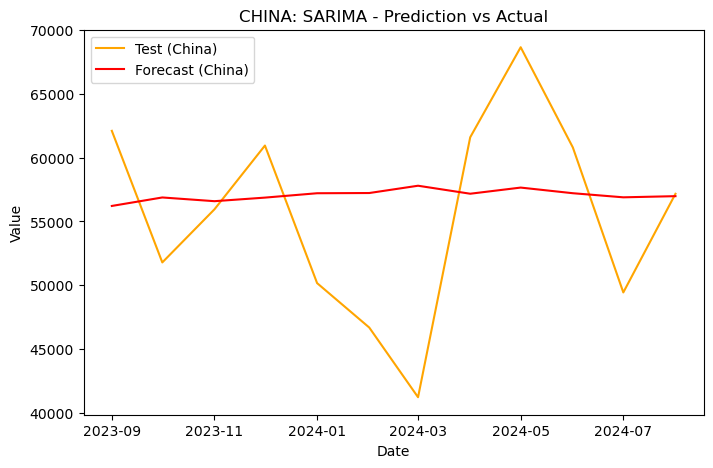

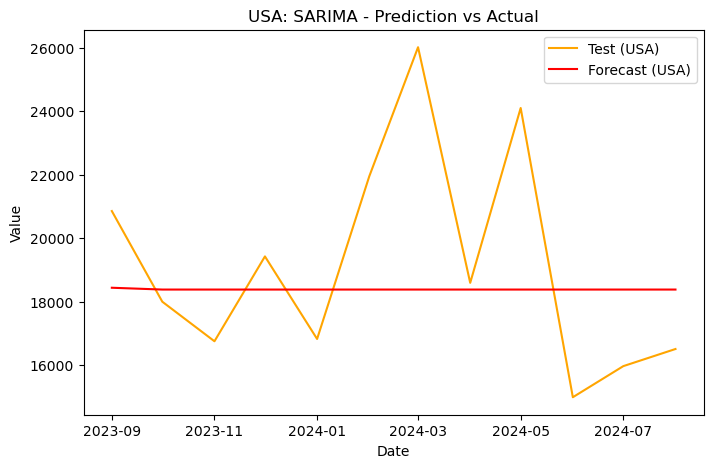

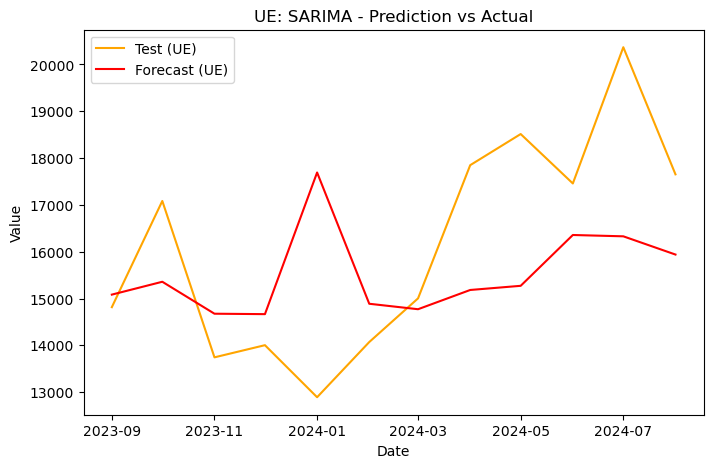

In [12]:
# 4.1 Plot for CHINA
plt.figure(figsize=(8, 5))
#plt.plot(train_china.index, train_china, label='Train (China)')
plt.plot(test_china.index, test_china, label='Test (China)', color='orange')
plt.plot(forecast_china.index, forecast_china, label='Forecast (China)', color='red')
plt.title('CHINA: SARIMA - Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


# 4.2 Plot for USA
plt.figure(figsize=(8, 5))
#plt.plot(train_usa.index, train_usa, label='Train (USA)')
plt.plot(test_usa.index, test_usa, label='Test (USA)', color='orange')
plt.plot(forecast_usa.index, forecast_usa, label='Forecast (USA)', color='red')
plt.title('USA: SARIMA - Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


# 4.3 Plot for UE
plt.figure(figsize=(8, 5))
#plt.plot(train_ue.index, train_ue, label='Train (UE)')
plt.plot(test_ue.index, test_ue, label='Test (UE)', color='orange')
plt.plot(forecast_ue.index, forecast_ue, label='Forecast (UE)', color='red')
plt.title('UE: SARIMA - Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_china, label='Entrenamiento (China)')
plt.plot(test_china, label='Test real (China)', color='orange')
plt.plot(forecast_china, label='Predicción (China)', color='green')
plt.title('SARIMA - Predicción vs Real (China)')
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.legend()
plt.show()


### División del Dataset en Datos de Entrenamiento y Datos de Testeo

### Modelado de datos

### Evaluación de Modelo

### Fine-Tuning de Modelo

#### Time Series Cross Validation

In [25]:
def ts_cross_validation_autoarima(
    series, 
    initial_train_size, 
    horizon, 
    n_splits
):
    """
    Realiza una validación cruzada 'expanding window' sobre la serie dada (1D).

    Parámetros:
    -----------
    series : pd.Series or pd.DataFrame (1-col)
        Serie de tiempo univariada con índice de tipo fecha. Debe ser 1D.
        Si es un DataFrame con una sola columna, usar .squeeze() o .iloc[:, 0].
    initial_train_size : int 
        Número de observaciones (meses) para el primer conjunto de entrenamiento.
    horizon : int 
        Número de pasos a pronosticar en cada fold (p.ej. 1, 3, 6...).
    n_splits : int 
        Cantidad de iteraciones en la validación cruzada.

    Retorna:
    --------
    dict con la media de las métricas: 'MAE', 'RMSE', 'MAPE'
    """
    
    # Asegurarnos de que 'series' sea Series 1D
    series_1d = series.squeeze()  # convierte DataFrame (n,1) en Series (n,)
    
    # Extraemos los valores en forma de array 1D
    y = series_1d.values  # shape (n,)
    n = len(y)
    
    # Para almacenar métricas de cada fold
    maes, rmses, mapes = [], [], []
    
    for i in range(n_splits):
        # Definir índices para train/valid
        train_end = initial_train_size + i*horizon
        valid_end = train_end + horizon
        
        # Evitar pasarse del largo de la serie
        if valid_end > n:
            break
        
        # Conjuntos de entrenamiento y validación (arrays 1D)
        y_train = y[:train_end]            # shape (train_end,)
        y_valid = y[train_end:valid_end]   # shape (horizon,)
        
        # Ajustar un modelo con auto_arima en y_train
        # (puedes expandir p, q, etc. para mayor búsqueda)
        model = auto_arima(
            y_train, 
            start_p=0, max_p=4, 
            start_q=0, max_q=4,
            seasonal=True, m=12,  # asumiendo estacionalidad mensual
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        
        # Predecir horizonte
        forecast = model.predict(n_periods=horizon)  # array 1D (horizon,)

        # Crear índices de validación
        index_valid = series_1d.index[train_end:valid_end]

        # Convertir ambos a Series para alinearlos y calcular métricas
        y_valid_series = pd.Series(y_valid, index=index_valid)
        forecast_series = pd.Series(forecast, index=index_valid)
        
        # Calcular métricas
        mae_fold = mean_absolute_error(y_valid_series, forecast_series)
        mse_fold = mean_squared_error(y_valid_series, forecast_series)
        rmse_fold = np.sqrt(mse_fold)
        mape_fold = mean_absolute_percentage_error(y_valid_series, forecast_series) * 100
        
        maes.append(mae_fold)
        rmses.append(rmse_fold)
        mapes.append(mape_fold)
    
    # Promediamos resultados de los folds
    cv_mae = np.mean(maes) if len(maes) > 0 else None
    cv_rmse = np.mean(rmses) if len(rmses) > 0 else None
    cv_mape = np.mean(mapes) if len(mapes) > 0 else None
    
    return {
        'MAE': cv_mae,
        'RMSE': cv_rmse,
        'MAPE': cv_mape
    }


In [32]:
# Convertir cada DF a Series (en caso de ser (n,1))
df_china_series = df_china.squeeze()  # O df_china.iloc[:,0] si prefieres
df_usa_series   = df_usa.squeeze()
df_ue_series    = df_ue.squeeze()

# Cross-Validation para CHINA
cv_china_result = ts_cross_validation_autoarima(
    series=df_china_series,
    initial_train_size=36,
    horizon=1,
    n_splits=12
)
print("==== Time Series CV (CHINA) ====")
print(f"MAE:  {cv_china_result['MAE']:.2f}")
print(f"RMSE: {cv_china_result['RMSE']:.2f}")
print(f"MAPE: {cv_china_result['MAPE']:.2f}%\n")

# Cross-Validation para USA
cv_usa_result = ts_cross_validation_autoarima(
    series=df_usa_series,
    initial_train_size=36,
    horizon=1,
    n_splits=12
)
print("==== Time Series CV (USA) ====")
print(f"MAE:  {cv_usa_result['MAE']:.2f}")
print(f"RMSE: {cv_usa_result['RMSE']:.2f}")
print(f"MAPE: {cv_usa_result['MAPE']:.2f}%\n")

# Cross-Validation para UE
cv_ue_result = ts_cross_validation_autoarima(
    series=df_ue_series,
    initial_train_size=36,
    horizon=1,
    n_splits=12
)
print("==== Time Series CV (UE) ====")
print(f"MAE:  {cv_ue_result['MAE']:.2f}")
print(f"RMSE: {cv_ue_result['RMSE']:.2f}")
print(f"MAPE: {cv_ue_result['MAPE']:.2f}%\n")


==== Time Series CV (CHINA) ====
MAE:  7545.44
RMSE: 7545.44
MAPE: 14.22%

==== Time Series CV (USA) ====
MAE:  3200.04
RMSE: 3200.04
MAPE: 17.13%

==== Time Series CV (UE) ====
MAE:  1655.75
RMSE: 1655.75
MAPE: 10.51%



### Evaluación Final de Modelo

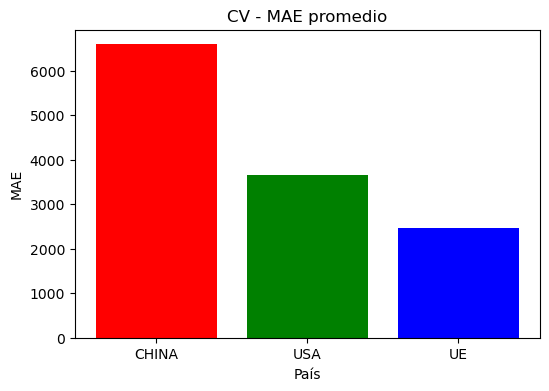

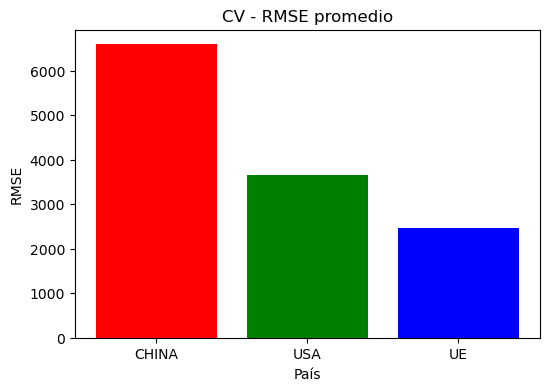

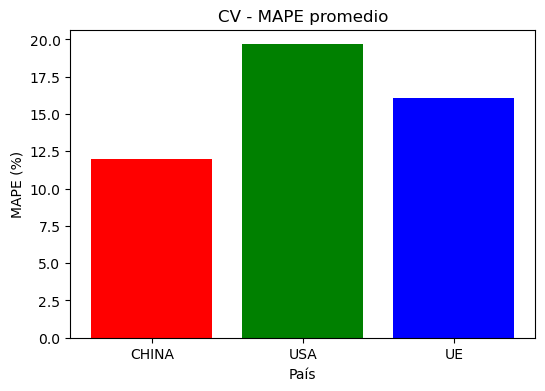

In [30]:
# -------------------------------------------------------------------
# 3. Visualizar los resultados de la CV (por ejemplo con barras)
#    Mostraremos para cada país 3 métricas: MAE, RMSE, MAPE
#    en un solo gráfico o en varios. Aquí va un ejemplo simple:
# -------------------------------------------------------------------

# Preparamos datos para MAE, RMSE y MAPE promedio de la CV
countries = ['CHINA', 'USA', 'UE']

cv_maes = [cv_china_result['MAE'], cv_usa_result['MAE'], cv_ue_result['MAE']]
cv_rmses = [cv_china_result['RMSE'], cv_usa_result['RMSE'], cv_ue_result['RMSE']]
cv_mapes = [cv_china_result['MAPE'], cv_usa_result['MAPE'], cv_ue_result['MAPE']]

# (a) Barras para MAE
plt.figure(figsize=(6, 4))
plt.bar(countries, cv_maes, color=['red','green','blue'])
plt.title('CV - MAE promedio')
plt.xlabel('País')
plt.ylabel('MAE')
plt.show()

# (b) Barras para RMSE
plt.figure(figsize=(6, 4))
plt.bar(countries, cv_rmses, color=['red','green','blue'])
plt.title('CV - RMSE promedio')
plt.xlabel('País')
plt.ylabel('RMSE')
plt.show()

# (c) Barras para MAPE
plt.figure(figsize=(6, 4))
plt.bar(countries, cv_mapes, color=['red','green','blue'])
plt.title('CV - MAPE promedio')
plt.xlabel('País')
plt.ylabel('MAPE (%)')
plt.show()




### Comparación Modelos RM sin y con Fine-Tuning

In [31]:
# -------------------------------------------------------------------
# 4. Comparar en una TABLA los resultados Baseline vs. CV
# -------------------------------------------------------------------
# Creamos un DataFrame resumen con columnas para cada métrica
# y filas para cada país

data_comparison = {
    'País': countries,
    # Baseline
    'Baseline MAE':  [mae_china, mae_usa, mae_ue],
    'Baseline RMSE': [rmse_china, rmse_usa, rmse_ue],
    'Baseline MAPE': [mape_china, mape_usa, mape_ue],
    # Cross-Validation
    'CV MAE':   [cv_china_result['MAE'], cv_usa_result['MAE'], cv_ue_result['MAE']],
    'CV RMSE':  [cv_china_result['RMSE'], cv_usa_result['RMSE'], cv_ue_result['RMSE']],
    'CV MAPE':  [cv_china_result['MAPE'], cv_usa_result['MAPE'], cv_ue_result['MAPE']]
}

df_comparison = pd.DataFrame(data_comparison)

# Ajustamos el orden de columnas si deseamos
df_comparison = df_comparison[[
    'País', 
    'Baseline MAE', 'CV MAE', 
    'Baseline RMSE', 'CV RMSE',
    'Baseline MAPE', 'CV MAPE'
]]

print("\n======== COMPARACIÓN BASELINE vs CROSS-VALIDATION ========")
print(df_comparison.to_string(index=False))



======== COMPARACIÓN BASELINE vs CROSS-VALIDATION ========
 País  Baseline MAE      CV MAE  Baseline RMSE     CV RMSE  Baseline MAPE   CV MAPE
CHINA   6380.297127 6595.503211    7763.227796 6595.503211      12.383616 11.996149
  USA   2655.089527 3665.389657    3378.092289 3665.389657      13.146155 19.665570
   UE   1850.395025 2476.117995    2349.368780 2476.117995      11.361637 16.043062


analisis y comentarios

## prueba 2

c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17216\2162476067.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_value = model.predict(n_periods=1)[0]
c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17216\2162476067.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

=== Métricas CHINA ===
{'MAE': 7292.14445851836, 'RMSE': 8301.719480653084, 'MAPE': 13.852882086174773}

=== Métricas USA ===
{'MAE': 3200.035487813931, 'RMSE': 3594.010748092615, 'MAPE': 17.134105582872852}

=== Métricas UE ===
{'MAE': 1676.5678596326816, 'RMSE': 1959.44574723522, 'MAPE': 10.47360640956358}


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17216\2162476067.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_value = model.predict(n_periods=1)[0]


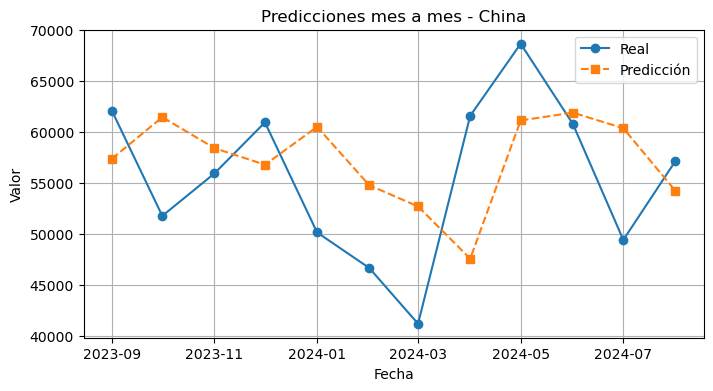

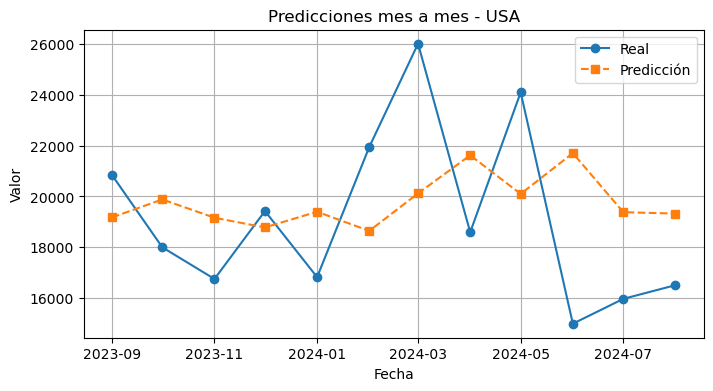

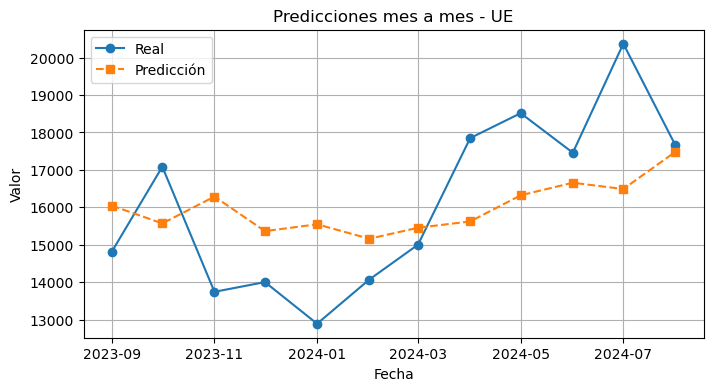

In [37]:
###############################################################################
# FUNCIONES
###############################################################################

def month_by_month_cv_autoarima(series, n_test=12):
    """
    Realiza un ciclo de validación mes a mes para el último año (n_test=12),
    usando todos los datos anteriores como entrenamiento.

    - Para cada uno de los últimos n_test meses:
      1) define la fecha de test,
      2) entrena un modelo auto_arima con datos hasta el mes anterior,
      3) predice 1 paso (horizon=1) en la fecha de test,
      4) guarda real y forecast en un DataFrame acumulado.

    Retorna:
    --------
    df_preds : DataFrame con columnas ['actual', 'forecast'] e índice de fechas.
    metrics : dict con {'MAE', 'RMSE', 'MAPE'} calculados sobre los n_test meses.
    """
    # Asegurar que sea Series 1D con índice de tipo fecha
    s = series.squeeze()
    s = s.asfreq('MS')  # opcional si deseas forzar freq inicio de mes
    s = s.sort_index()  # ordenar por seguridad

    # Últimos n_test meses (fechas de test)
    # Por ejemplo, si n_test=12 y la serie llega a 2024-08, 
    # esto tomará las 12 fechas mensuales previas.
    test_dates = s.index[-n_test:]

    # Almacenaremos aquí las predicciones
    all_forecasts = []
    
    for test_date in test_dates:
        # Datos de entrenamiento: todo hasta el mes anterior a test_date
        train_end = test_date - pd.offsets.MonthBegin(1)  # mes anterior
        train_data = s.loc[:train_end]

        # Ajustar modelo auto_arima con todos los datos de train_data
        model = auto_arima(
            train_data,
            start_p=0, max_p=6,
            start_q=0, max_q=6,
            seasonal=False, m=12,     # asumiendo posible estacionalidad anual
            trace=False, 
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        
        # Pronosticar 1 paso en test_date
        forecast_value = model.predict(n_periods=1)[0]
        actual_value = s.loc[test_date]

        all_forecasts.append((test_date, actual_value, forecast_value))

    # Convertir resultados a DataFrame
    df_preds = pd.DataFrame(all_forecasts, columns=['date', 'actual', 'forecast'])
    df_preds.set_index('date', inplace=True)
    
    # Calcular métricas globales
    mae = mean_absolute_error(df_preds['actual'], df_preds['forecast'])
    rmse = np.sqrt(mean_squared_error(df_preds['actual'], df_preds['forecast']))
    mape = mean_absolute_percentage_error(df_preds['actual'], df_preds['forecast']) * 100

    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

    return df_preds, metrics

def plot_month_by_month_results(df_preds, country_name):
    """
    Grafica las predicciones vs los valores reales para el DataFrame generado
    por month_by_month_cv_autoarima.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(df_preds.index, df_preds['actual'], label='Real', marker='o')
    plt.plot(df_preds.index, df_preds['forecast'], label='Predicción', marker='s', linestyle='--')
    plt.title(f'Predicciones mes a mes - {country_name}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

###############################################################################
# SUPONIENDO QUE YA TIENES df_china, df_usa y df_ue
# Cada uno con índice datetime mensual y una sola columna numérica.
# EJEMPLO DE USO:
###############################################################################

# 1) Calcular las predicciones mes a mes para el último año (n_test=12)
#    usando todos los datos previos como entrenamiento.

df_china_preds, china_metrics = month_by_month_cv_autoarima(df_china, n_test=12)
df_usa_preds, usa_metrics     = month_by_month_cv_autoarima(df_usa,   n_test=12)
df_ue_preds, ue_metrics       = month_by_month_cv_autoarima(df_ue,    n_test=12)

# 2) Imprimir métricas
print("=== Métricas CHINA ===")
print(china_metrics)
print("\n=== Métricas USA ===")
print(usa_metrics)
print("\n=== Métricas UE ===")
print(ue_metrics)

# 3) Graficar resultados
plot_month_by_month_results(df_china_preds, 'China')
plot_month_by_month_results(df_usa_preds,   'USA')
plot_month_by_month_results(df_ue_preds,    'UE')

In [34]:
print("==== BASELINE METRICS ====")
print(f"CHINA  -> MAE: {mae_china:.2f}, RMSE: {rmse_china:.2f}, MAPE: {mape_china:.2f}%")
print(f"USA    -> MAE: {mae_usa:.2f},  RMSE: {rmse_usa:.2f},  MAPE: {mape_usa:.2f}%")
print(f"UE     -> MAE: {mae_ue:.2f},   RMSE: {rmse_ue:.2f},   MAPE: {mape_ue:.2f}%\n")

# -------------------------------------------------------------------
# 2) MÉTRICAS DEL MODELO MES A MES
# -------------------------------------------------------------------
print("==== MONTH BY MONTH METRICS ====")
print(f"CHINA  -> MAE: {china_metrics['MAE']:.2f}, RMSE: {china_metrics['RMSE']:.2f}, MAPE: {china_metrics['MAPE']:.2f}%")
print(f"USA    -> MAE: {usa_metrics['MAE']:.2f},  RMSE: {usa_metrics['RMSE']:.2f},  MAPE: {usa_metrics['MAPE']:.2f}%")
print(f"UE     -> MAE: {ue_metrics['MAE']:.2f},   RMSE: {ue_metrics['RMSE']:.2f},   MAPE: {ue_metrics['MAPE']:.2f}%\n")

# -------------------------------------------------------------------
# 3) CREAMOS UN DATAFRAME COMPARATIVO
#    (filas = [Baseline, MonthByMonth], columnas = Métricas de cada país)
# -------------------------------------------------------------------
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'MonthByMonth'],

    'CHINA_MAE':  [mae_china,  china_metrics['MAE']],
    'CHINA_RMSE': [rmse_china, china_metrics['RMSE']],
    'CHINA_MAPE': [mape_china, china_metrics['MAPE']],

    'USA_MAE':    [mae_usa,    usa_metrics['MAE']],
    'USA_RMSE':   [rmse_usa,   usa_metrics['RMSE']],
    'USA_MAPE':   [mape_usa,   usa_metrics['MAPE']],

    'UE_MAE':     [mae_ue,     ue_metrics['MAE']],
    'UE_RMSE':    [rmse_ue,    ue_metrics['RMSE']],
    'UE_MAPE':    [mape_ue,    ue_metrics['MAPE']],
})

# Reordenamos columnas si quieres: (opcional)
comparison_df = comparison_df[[
    'Model',
    'CHINA_MAE', 'CHINA_RMSE', 'CHINA_MAPE',
    'USA_MAE',   'USA_RMSE',   'USA_MAPE',
    'UE_MAE',    'UE_RMSE',    'UE_MAPE'
]]

print("======== COMPARACIÓN BASELINE vs. MES A MES ========")
print(comparison_df.to_string(index=False))



==== BASELINE METRICS ====
CHINA  -> MAE: 6380.30, RMSE: 7763.23, MAPE: 12.38%
USA    -> MAE: 2655.09,  RMSE: 3378.09,  MAPE: 13.15%
UE     -> MAE: 1850.40,   RMSE: 2349.37,   MAPE: 11.36%

==== MONTH BY MONTH METRICS ====
CHINA  -> MAE: 7545.44, RMSE: 8571.71, MAPE: 14.22%
USA    -> MAE: 3200.04,  RMSE: 3594.01,  MAPE: 17.13%
UE     -> MAE: 1655.75,   RMSE: 2239.79,   MAPE: 10.51%

======== COMPARACIÓN BASELINE vs. MES A MES ========
       Model   CHINA_MAE  CHINA_RMSE  CHINA_MAPE     USA_MAE    USA_RMSE  USA_MAPE      UE_MAE     UE_RMSE   UE_MAPE
    Baseline 6380.297127 7763.227796   12.383616 2655.089527 3378.092289 13.146155 1850.395025 2349.368780 11.361637
MonthByMonth 7545.441540 8571.705590   14.222119 3200.035488 3594.010748 17.134106 1655.747934 2239.792531 10.508816


### Prueba 3

c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17216\1398570899.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_value_log = model.predict(n_periods=1)[0]
c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17216\1398570899.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated 

=== Métricas CHINA (Log->Exp) ===
{'MAE': 8181.648742493581, 'RMSE': 9858.393550812038, 'MAPE': 15.743571250498864}

=== Métricas USA (Log->Exp) ===
{'MAE': 3386.280282815227, 'RMSE': 3852.0511676280657, 'MAPE': 18.417051542932672}

=== Métricas UE (Log->Exp) ===
{'MAE': 1582.395220617551, 'RMSE': 1854.4803026517425, 'MAPE': 9.809801134011025}


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17216\1398570899.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_value_log = model.predict(n_periods=1)[0]


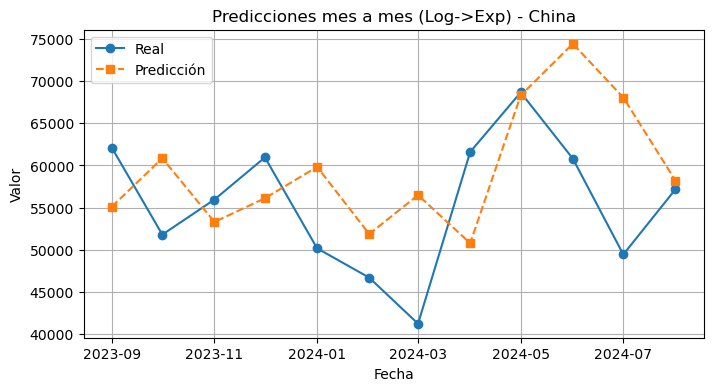

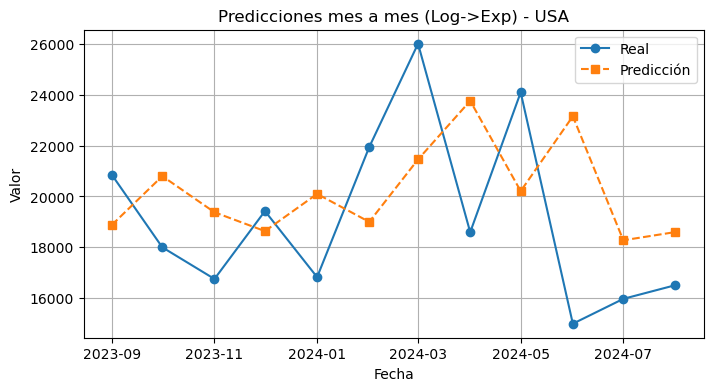

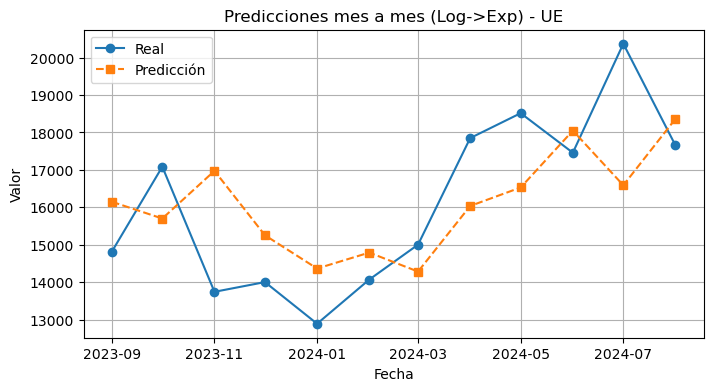

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

###############################################################################
# FUNCIONES
###############################################################################

def month_by_month_cv_autoarima_log(series, n_test=12):
    """
    Realiza un ciclo de validación mes a mes para el último año (n_test=12),
    usando todos los datos anteriores como entrenamiento, pero con
    TRANSFORMACIÓN LOGARÍTMICA para estabilizar varianzas o tendencias multiplicativas.

    PASOS:
      - Para cada uno de los últimos n_test meses (test_date):
        1) define la fecha de test,
        2) entrena un modelo auto_arima con datos log-transformados
           hasta el mes anterior a test_date,
        3) predice 1 paso en la escala log,
        4) lleva esa predicción a la escala original con exp(),
        5) guarda (fecha, real_original, forecast_original) en un DataFrame.

    Retorna:
    --------
    df_preds : DataFrame con columnas ['actual', 'forecast'] e índice de fechas
               (escala original).
    metrics : dict con {'MAE', 'RMSE', 'MAPE'} calculados sobre los n_test meses
              en escala original.
    """
    # Asegurar que sea Series 1D con índice de tipo fecha
    s = series.squeeze()
    s = s.asfreq('MS')  # opcional si deseas forzar freq start of month
    s = s.sort_index()  # ordenar por seguridad

    # IMPORTANTE: verificar que no existan ceros o negativos en la serie
    # Caso contrario, habría que sumarle un eps o un +1 si hay ceros.
    if (s <= 0).any():
        raise ValueError("Existen valores <= 0 en la serie, no se puede aplicar log directa.")

    # Últimos n_test meses (fechas de test)
    test_dates = s.index[-n_test:]

    # Almacenaremos aquí las predicciones (escala original)
    all_forecasts = []
    
    for test_date in test_dates:
        # Datos de entrenamiento: todo hasta el mes anterior a test_date
        train_end = test_date - pd.offsets.MonthBegin(1)
        train_data = s.loc[:train_end]  # escala original

        # =========================
        # 1) Transformación log
        # =========================
        train_data_log = np.log(train_data)

        # Ajustar modelo en escala log
        model = auto_arima(
            train_data_log,
            start_p=0, max_p=5,
            start_q=0, max_q=5,
            seasonal=False, m=12,  # asumiendo posible estacionalidad anual
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )

        # Pronosticar 1 paso en escala log
        forecast_value_log = model.predict(n_periods=1)[0]

        # Convertir pronóstico a escala original
        forecast_value = np.exp(forecast_value_log)

        # Valor real en escala original (de la serie original)
        actual_value = s.loc[test_date]

        all_forecasts.append((test_date, actual_value, forecast_value))

    # Convertir resultados a DataFrame
    df_preds = pd.DataFrame(all_forecasts, columns=['date', 'actual', 'forecast'])
    df_preds.set_index('date', inplace=True)
    
    # Calcular métricas globales en ESCALA ORIGINAL
    mae = mean_absolute_error(df_preds['actual'], df_preds['forecast'])
    rmse = np.sqrt(mean_squared_error(df_preds['actual'], df_preds['forecast']))
    mape = mean_absolute_percentage_error(df_preds['actual'], df_preds['forecast']) * 100

    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

    return df_preds, metrics


def plot_month_by_month_results(df_preds, country_name):
    """
    Grafica las predicciones vs los valores reales para el DataFrame generado
    por month_by_month_cv_autoarima (ahora versión log).
    """
    plt.figure(figsize=(8, 4))
    plt.plot(df_preds.index, df_preds['actual'], label='Real', marker='o')
    plt.plot(df_preds.index, df_preds['forecast'], label='Predicción', marker='s', linestyle='--')
    plt.title(f'Predicciones mes a mes (Log->Exp) - {country_name}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

###############################################################################
# EJEMPLO DE USO (con df_china, df_usa, df_ue):
###############################################################################

# 1) Calcular las predicciones mes a mes para el último año (n_test=12)
#    usando log-transform + todo el histórico anterior.
df_china_preds_log, china_metrics_log = month_by_month_cv_autoarima_log(df_china, n_test=12)
df_usa_preds_log,   usa_metrics_log   = month_by_month_cv_autoarima_log(df_usa,   n_test=12)
df_ue_preds_log,    ue_metrics_log    = month_by_month_cv_autoarima_log(df_ue,    n_test=12)

# 2) Imprimir métricas
print("=== Métricas CHINA (Log->Exp) ===")
print(china_metrics_log)
print("\n=== Métricas USA (Log->Exp) ===")
print(usa_metrics_log)
print("\n=== Métricas UE (Log->Exp) ===")
print(ue_metrics_log)

# 3) Graficar resultados
plot_month_by_month_results(df_china_preds_log, 'China')
plot_month_by_month_results(df_usa_preds_log,   'USA')
plot_month_by_month_results(df_ue_preds_log,    'UE')


c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarn

=== Métricas CHINA (Box-Cox) ===
{'MAE': 7903.000522107046, 'RMSE': 9053.292512328024, 'MAPE': 14.937065064634394}

=== Métricas USA (Box-Cox) ===
{'MAE': 3201.127021474303, 'RMSE': 3754.8239382064003, 'MAPE': 17.05151901621238}

=== Métricas UE (Box-Cox) ===
{'MAE': 1797.6655990087795, 'RMSE': 2076.3783238466135, 'MAPE': 11.351344310192902}


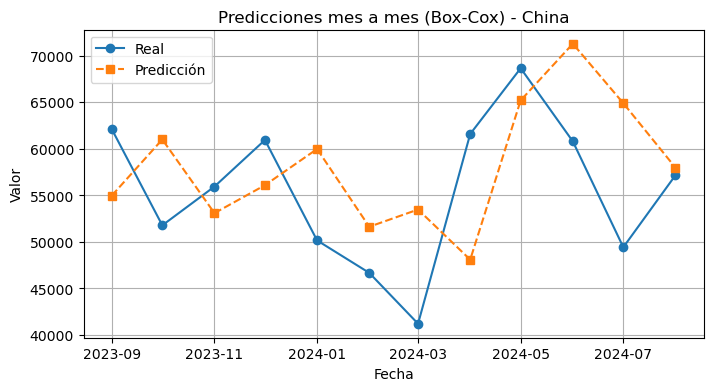

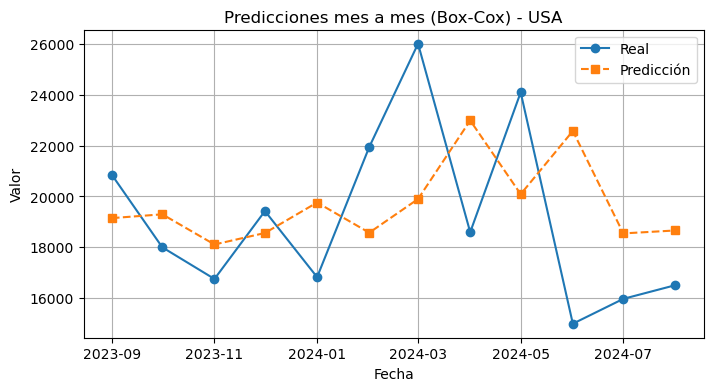

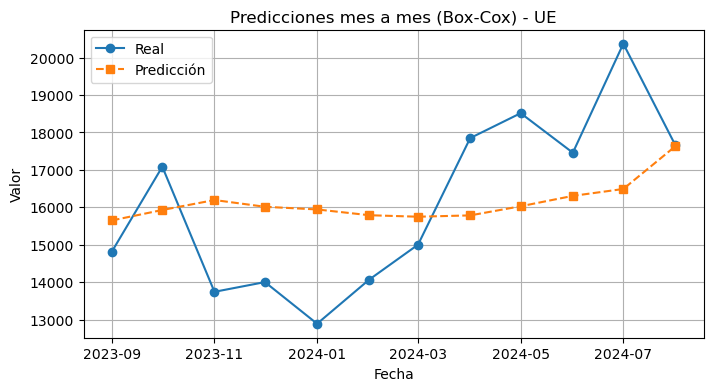

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import boxcox
from scipy.special import inv_boxcox

###############################################################################
# FUNCIONES
###############################################################################

def month_by_month_cv_autoarima_boxcox(series, n_test=12):
    """
    Realiza un ciclo de validación mes a mes para el último año (n_test=12),
    usando todos los datos anteriores como entrenamiento, con TRANSFORMACIÓN BOX-COX
    para estabilizar varianzas o tendencias multiplicativas.

    PASOS:
      - Para cada uno de los últimos n_test meses (test_date):
        1) define la fecha de test,
        2) aplica Box-Cox a los datos de entrenamiento,
        3) entrena un modelo auto_arima con datos transformados,
        4) predice 1 paso en la escala transformada,
        5) lleva esa predicción a la escala original con la inversa de Box-Cox,
        6) guarda (fecha, real_original, forecast_original) en un DataFrame.

    Retorna:
    --------
    df_preds : DataFrame con columnas ['actual', 'forecast'] e índice de fechas
               (escala original).
    metrics : dict con {'MAE', 'RMSE', 'MAPE'} calculados sobre los n_test meses
              en escala original.
    """
    # Asegurar que sea Series 1D con índice de tipo fecha
    s = series.squeeze()
    s = s.asfreq('MS')  # opcional si deseas forzar freq start of month
    s = s.sort_index()  # ordenar por seguridad

    # IMPORTANTE: verificar valores <= 0 y desplazarlos si es necesario
    if (s <= 0).any():
        shift_value = abs(s.min()) + 1  # Calcular desplazamiento para valores positivos
    else:
        shift_value = 0

    # Últimos n_test meses (fechas de test)
    test_dates = s.index[-n_test:]

    # Almacenaremos aquí las predicciones (escala original)
    all_forecasts = []

    for test_date in test_dates:
        # Datos de entrenamiento: todo hasta el mes anterior a test_date
        train_end = test_date - pd.offsets.MonthBegin(1)
        train_data = s.loc[:train_end] + shift_value  # Escala original desplazada

        # =========================
        # 1) Transformación Box-Cox
        # =========================
        train_data_boxcox, lambda_boxcox = boxcox(train_data)

        # Ajustar modelo en escala Box-Cox
        model = auto_arima(
            train_data_boxcox,
            start_p=0, max_p=5,
            start_q=0, max_q=5,
            seasonal=False, m=12,  # asumiendo posible estacionalidad anual
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )

        # Pronosticar 1 paso en escala Box-Cox
        forecast_value_boxcox = model.predict(n_periods=1)[0]

        # Convertir pronóstico a escala original
        forecast_value = inv_boxcox(forecast_value_boxcox, lambda_boxcox) - shift_value

        # Valor real en escala original (de la serie original)
        actual_value = s.loc[test_date]

        all_forecasts.append((test_date, actual_value, forecast_value))

    # Convertir resultados a DataFrame
    df_preds = pd.DataFrame(all_forecasts, columns=['date', 'actual', 'forecast'])
    df_preds.set_index('date', inplace=True)

    # Calcular métricas globales en ESCALA ORIGINAL
    mae = mean_absolute_error(df_preds['actual'], df_preds['forecast'])
    rmse = np.sqrt(mean_squared_error(df_preds['actual'], df_preds['forecast']))
    mape = mean_absolute_percentage_error(df_preds['actual'], df_preds['forecast']) * 100

    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

    return df_preds, metrics


def plot_month_by_month_results(df_preds, country_name):
    """
    Grafica las predicciones vs los valores reales para el DataFrame generado
    por month_by_month_cv_autoarima_boxcox.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(df_preds.index, df_preds['actual'], label='Real', marker='o')
    plt.plot(df_preds.index, df_preds['forecast'], label='Predicción', marker='s', linestyle='--')
    plt.title(f'Predicciones mes a mes (Box-Cox) - {country_name}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

###############################################################################
# EJEMPLO DE USO (con df_china, df_usa, df_ue):
###############################################################################

# 1) Calcular las predicciones mes a mes para el último año (n_test=12)
df_china_preds_boxcox, china_metrics_boxcox = month_by_month_cv_autoarima_boxcox(df_china, n_test=12)
df_usa_preds_boxcox,   usa_metrics_boxcox   = month_by_month_cv_autoarima_boxcox(df_usa,   n_test=12)
df_ue_preds_boxcox,    ue_metrics_boxcox    = month_by_month_cv_autoarima_boxcox(df_ue,    n_test=12)

# 2) Imprimir métricas
print("=== Métricas CHINA (Box-Cox) ===")
print(china_metrics_boxcox)
print("\n=== Métricas USA (Box-Cox) ===")
print(usa_metrics_boxcox)
print("\n=== Métricas UE (Box-Cox) ===")
print(ue_metrics_boxcox)

# 3) Graficar resultados
plot_month_by_month_results(df_china_preds_boxcox, 'China')
plot_month_by_month_results(df_usa_preds_boxcox,   'USA')
plot_month_by_month_results(df_ue_preds_boxcox,    'UE')


### Comparación del Desempeño de Modelos